In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.transforms import functional as TF
from torchvision.transforms.functional import to_pil_image
from model import CCAE
from data_loader import ImageDataset
import json
from types import SimpleNamespace
import imageio

args = SimpleNamespace(
    checkpoint='best_model/best_ema_model.pth',
    csv_file='../VD-FEBE-Data/PreIP_512_FEB25/data_labels.csv',
    image_folder='../VD-FEBE-Data/PreIP_512_FEB25/XYImages_Smoothed',
    norm_file='../VD-FEBE-Data/PreIP_512_FEB25/normalization.json',
    output_dir='quad_scan_demo',
    quad_index=0
)

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

# Load stats
with open(args.norm_file, "r") as f:
    norm_stats = json.load(f)
means = np.array(norm_stats["means"])
stds = np.array(norm_stats["stds"])

# Load dataset
df = pd.read_csv(args.csv_file)
dataset = ImageDataset(df, args.image_folder, means, stds)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Load model and set to eval mode
model = CCAE(base_channels=32).to(device)
model.load_state_dict(torch.load('best_model/best_ema_model.pth', map_location=device))
model.eval()

# Load one sample (batch size = 1)
img_in, img_target, cond_gt = dataset[0]  # Replace with desired index
img_in = img_in.unsqueeze(0).to(device)
img_target = img_target.unsqueeze(0).to(device)


/tmp/ipykernel_1206331/123800462.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model/best_ema_model.pth', map_location=device))

In [2]:
# Initialize conditioning variable as a learnable parameter
cond_opt = torch.randn_like(cond_gt.unsqueeze(0), device=device, requires_grad=True)

# Optimizer
optimizer = torch.optim.Adam([cond_opt], lr=0.05)

# Store losses for plotting
losses = []

# Optimization loop
print(cond_opt.shape)
for step in range(300):  # You can adjust the number of steps
    optimizer.zero_grad()

    with torch.no_grad():
        bottleneck = model.encode(img_in)

    # Forward through decoder
    img_pred = model.decode(bottleneck, cond_opt)

    # Compute image reconstruction loss
    loss = F.mse_loss(img_pred, img_target)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if step % 50 == 0 or step == 299:
        print(f"[Step {step}] Loss: {loss.item():.6f}")


torch.Size([1, 4])
[Step 0] Loss: 0.032484
[Step 50] Loss: 0.002223
[Step 100] Loss: 0.002076
[Step 150] Loss: 0.002059
[Step 200] Loss: 0.002053
[Step 250] Loss: 0.002052
[Step 299] Loss: 0.002053


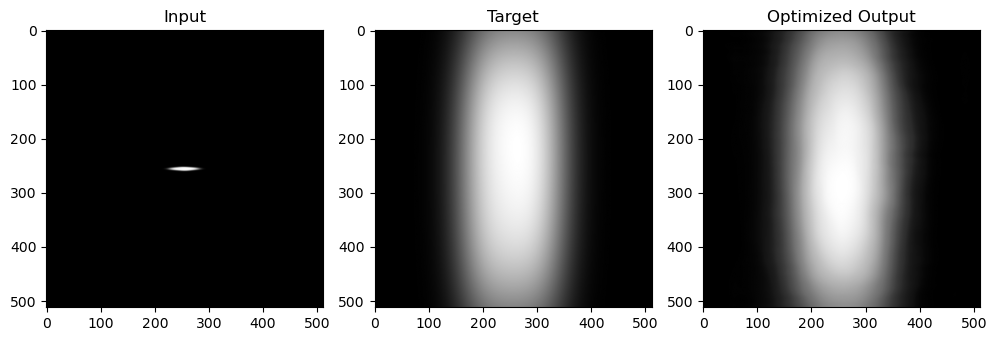

Ground Truth Conditioning: [-0.5927363 -1.0872891 -0.9588326 -0.2872184]
Optimized Conditioning: [-1.4092063   0.06863558  0.9242478  -0.37086096]


In [3]:
# Convert to numpy
input_np = img_in.squeeze().cpu().numpy()
target_np = img_target.squeeze().cpu().numpy()
pred_np = img_pred.squeeze().detach().cpu().numpy()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(input_np, cmap='gray')
axs[0].set_title("Input")

axs[1].imshow(target_np, cmap='gray')
axs[1].set_title("Target")

axs[2].imshow(pred_np, cmap='gray')
axs[2].set_title("Optimized Output")

plt.tight_layout()
plt.show()

# Print optimized vs ground truth conditions
print("Ground Truth Conditioning:", cond_gt.cpu().numpy())
print("Optimized Conditioning:", cond_opt.detach().cpu().numpy().squeeze())


In [8]:
# Load one sample (batch size = 1)
img_in, img_target, cond_gt = dataset[0]  # Replace with desired index
img_in = img_in.unsqueeze(0).to(device)
cond_in = cond_gt.unsqueeze(0).to(device)
model.eval()

# Settings
n_steps = 21  # e.g. scan from -3σ to +3σ with 21 points
save_dir = "quad_scan_outputs"
os.makedirs(save_dir, exist_ok=True)

# Prepare scan range: from -3 to +3 standard deviations
scan_range = np.linspace(-3, 3, n_steps)

# Scan each conditioning variable
for i in range(4):  # Assuming 4 quads
    print(f"Scanning quad index {i}...")
    frames = []
    fig, axs = plt.subplots(1, n_steps, figsize=(3 * n_steps, 3))

    for j, delta_sigma in enumerate(scan_range):
        cond_scan = cond_in.clone()  # (1, 4)

        # Convert σ-shift to normalized units
        delta = torch.tensor(delta_sigma * stds[i], device=device)
        cond_scan[0, i] = (means[i] + delta)  # De-normalize first

        # Re-normalize the full condition vector (if needed)
        #cond_scan_norm = (cond_scan - torch.tensor(means, dtype=torch.float32, device=device)) / torch.tensor(stds, dtype=torch.float32, device=device)
        #cond_scan_torch = torch.tensor(cond_scan, dtype=torch.float32, device=device)

        # Encode and decode
        #print(img_in.shape)
        #print(cond_scan_norm.shape)
        #print(cond_scan_norm.dtype, model.cond_embed[0].weight.dtype)
        with torch.no_grad():
            bottleneck = model.encode(img_in)
            pred_img = model.decode(bottleneck, cond_scan)

        pred_np = pred_img.squeeze().cpu().numpy()
        
        axs[j].imshow(pred_np, cmap='gray')
        axs[j].axis('off')
        axs[j].set_title(f'{delta_sigma:.1f}σ')

        img_np = (pred_np + 1) / 2  # Tanh rescale from [-1, 1] to [0, 1]
        img_uint8 = (img_np * 255).astype(np.uint8)

        # Resize to PIL image for imageio
        pil_img = to_pil_image(img_uint8)
        frames.append(np.array(pil_img))

    plt.suptitle(f'Quad {i} Scan: {n_steps} steps from -3σ to +3σ', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'quad_scan_{i}.png'))
    plt.close()

    gif_path = os.path.join(save_dir, f'quad_scan_{i}.gif')
    imageio.mimsave(gif_path, frames, fps=5)
    print(f"Saved GIF to {gif_path}")

Scanning quad index 0...
Saved GIF to quad_scan_outputs/quad_scan_0.gif
Scanning quad index 1...
Saved GIF to quad_scan_outputs/quad_scan_1.gif
Scanning quad index 2...
Saved GIF to quad_scan_outputs/quad_scan_2.gif
Scanning quad index 3...
Saved GIF to quad_scan_outputs/quad_scan_3.gif
